# Hamiltonian grouping

In [1]:
from functools import partial
from qiskit.quantum_info import SparsePauliOp, random_statevector
import multiprocessing

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy
import jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
# from lightcone import *
from spin_ham import *
from trotter import *
from bounds import *
# from noise import *

figs_dir, data_dir = './figs', './data'

## Nearest-neighbor Heisenberg 

### Different groupings

J=1, h=0.2, t=0.5, r=5
ob error (operator norm, largest eigen):  0.0006050279016702327 ; r: 5 ; t: 0.5
ob error (operator norm, largest eigen):  0.0003890797716265801 ; r: 5 ; t: 0.5
n=4, empirical error_xyz=0.000605, empirical error_parity=0.000389
ob error (operator norm, largest eigen):  0.0006461088136168175 ; r: 5 ; t: 0.5
ob error (operator norm, largest eigen):  0.0004722297915785203 ; r: 5 ; t: 0.5
n=5, empirical error_xyz=0.000646, empirical error_parity=0.000472
ob error (operator norm, largest eigen):  0.0006683464066081828 ; r: 5 ; t: 0.5
ob error (operator norm, largest eigen):  0.0004518195344625213 ; r: 5 ; t: 0.5
n=6, empirical error_xyz=0.000668, empirical error_parity=0.000452
ob error (operator norm, largest eigen):  0.0006868572656431326 ; r: 5 ; t: 0.5
ob error (operator norm, largest eigen):  0.0005011031698569969 ; r: 5 ; t: 0.5
n=7, empirical error_xyz=0.000687, empirical error_parity=0.000501
ob error (operator norm, largest eigen):  0.0006991156194007036 ; r: 

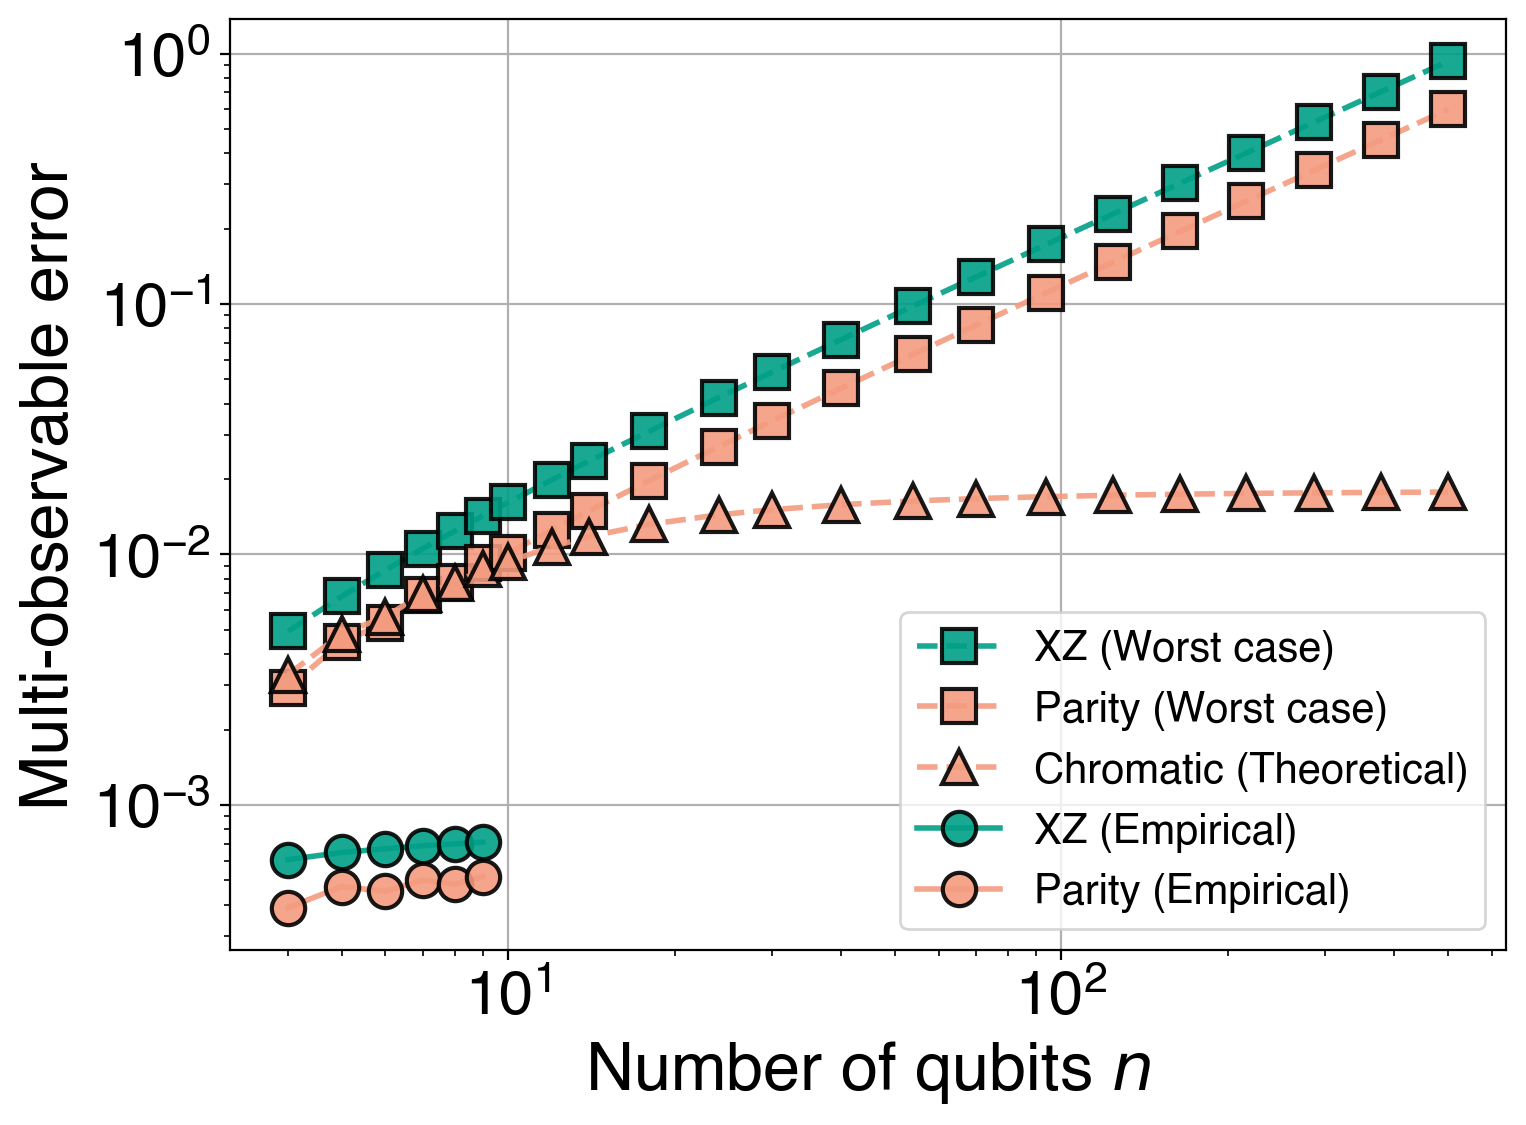

In [14]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
# n = 8; 
t = 0.5
r = 5
# n_list = np.linspace(4, 500, 20, dtype=int)
n_list = [4, 5, 6, 7, 8, 9, 10, 12, 14,  18,  24,  30,  40,  54,  70,  94, 124, 164, 216, 286, 378, 500]
n_list_emp = range(4, 10)
data = {'error_xyz': [], 'error_parity': [], 'error_standard': [], 'error_xyz_emp': [], 'error_parity_emp': []}
print(f"J={J}, h={h}, t={t}, r={r}")
for n in n_list:
    error_xyz = analy_st_loose_bound(r, n, J, h, t, group='xyz')
    error_standard = analy_st_loose_bound(r, n, J, h, t, group='parity')
    error_parity = analy_lc_bound(r, n, J, h, t, ob_type='multi')
    data['error_xyz'].append(error_xyz)
    data['error_standard'].append(error_standard)
    data['error_parity'].append(error_parity)
    # print(f"n={n}, empirical error_xyz={error_xyz}, empirical error_parity={error_parity}")  

def ob_error(ob, exact_U, appro_U):
    exact_ob = exact_U.conj().T @ ob @ exact_U 
    appro_ob = appro_U.conj().T @ ob @ appro_U
    # ob_error = np.linalg.norm(exact_ob - appro_ob, ord=2)
    ob_error = np.sort(abs(np.linalg.eigvalsh(exact_ob - appro_ob)))[-1]
    print('ob error (operator norm, largest eigen): ', ob_error, '; r:', r, '; t:', t)
    return ob_error

for n in n_list_emp:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = pf_r([h.to_matrix(True) for h in tfI.ham_xyz], t, r, use_jax=False)
    # appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = pf_r([h.to_matrix(True) for h in tfI.ham_parity], t, r, use_jax=False)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    # z_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
    error_xyz = ob_error(magn_op.to_matrix(), exact_U, appro_U_xyz)
    error_parity = ob_error(magn_op.to_matrix(), exact_U, appro_U_parity)
    data['error_xyz_emp'].append(error_xyz)
    data['error_parity_emp'].append(error_parity)
    print(f"n={n}, empirical error_xyz={error_xyz:.6f}, empirical error_parity={error_parity:.6f}")  

fig, ax = plt.subplots(figsize=(8, 6), layout='tight')
ax.plot(n_list, data['error_xyz'], 's--', color='#00A087FF', label='XZ (Worst case)')
ax.plot(n_list, data['error_standard'], 's--', color='#F39B7FFF', label='Parity (Worst case)')
ax.plot(n_list, data['error_parity'], '^--', color='#F39B7FFF', label='Chromatic (Theoretical)')
ax.plot(n_list_emp, data['error_xyz_emp'], 'o-', color='#00A087FF', label='XZ (Empirical)')
ax.plot(n_list_emp, data['error_parity_emp'], 'o-', color='#F39B7FFF', label='Parity (Empirical)')
ax.loglog()
ax.set_xlabel(rf'Number of qubits $n$')
# ax.set_title(f't={t}, r={r}')
# ax.set_yscale('log')
ax.grid()
ax.set_ylabel('Multi-observable error')
ax.legend() 
fig.savefig(f'./figs/grouping_TFI1d_n={n}_Multi_t={t}.pdf', bbox_inches='tight')

J=1, h=0.2, t=0.5, r=30
n=8, empirical error_xyz=0.000019, empirical error_parity=0.000013
n=8, empirical error_xyz=0.000039, empirical error_parity=0.000027
n=8, empirical error_xyz=0.000062, empirical error_parity=0.000043
n=8, empirical error_xyz=0.000084, empirical error_parity=0.000060
n=8, empirical error_xyz=0.000101, empirical error_parity=0.000075
n=8, empirical error_xyz=0.000109, empirical error_parity=0.000101
n=8, empirical error_xyz=0.000113, empirical error_parity=0.000138
n=8, empirical error_xyz=0.000138, empirical error_parity=0.000184
n=8, empirical error_xyz=0.000207, empirical error_parity=0.000241
n=8, empirical error_xyz=0.000300, empirical error_parity=0.000309
n=8, empirical error_xyz=0.000399, empirical error_parity=0.000389
n=8, empirical error_xyz=0.000489, empirical error_parity=0.000479
n=8, empirical error_xyz=0.000559, empirical error_parity=0.000579
n=8, empirical error_xyz=0.000609, empirical error_parity=0.000688
n=8, empirical error_xyz=0.000661, emp

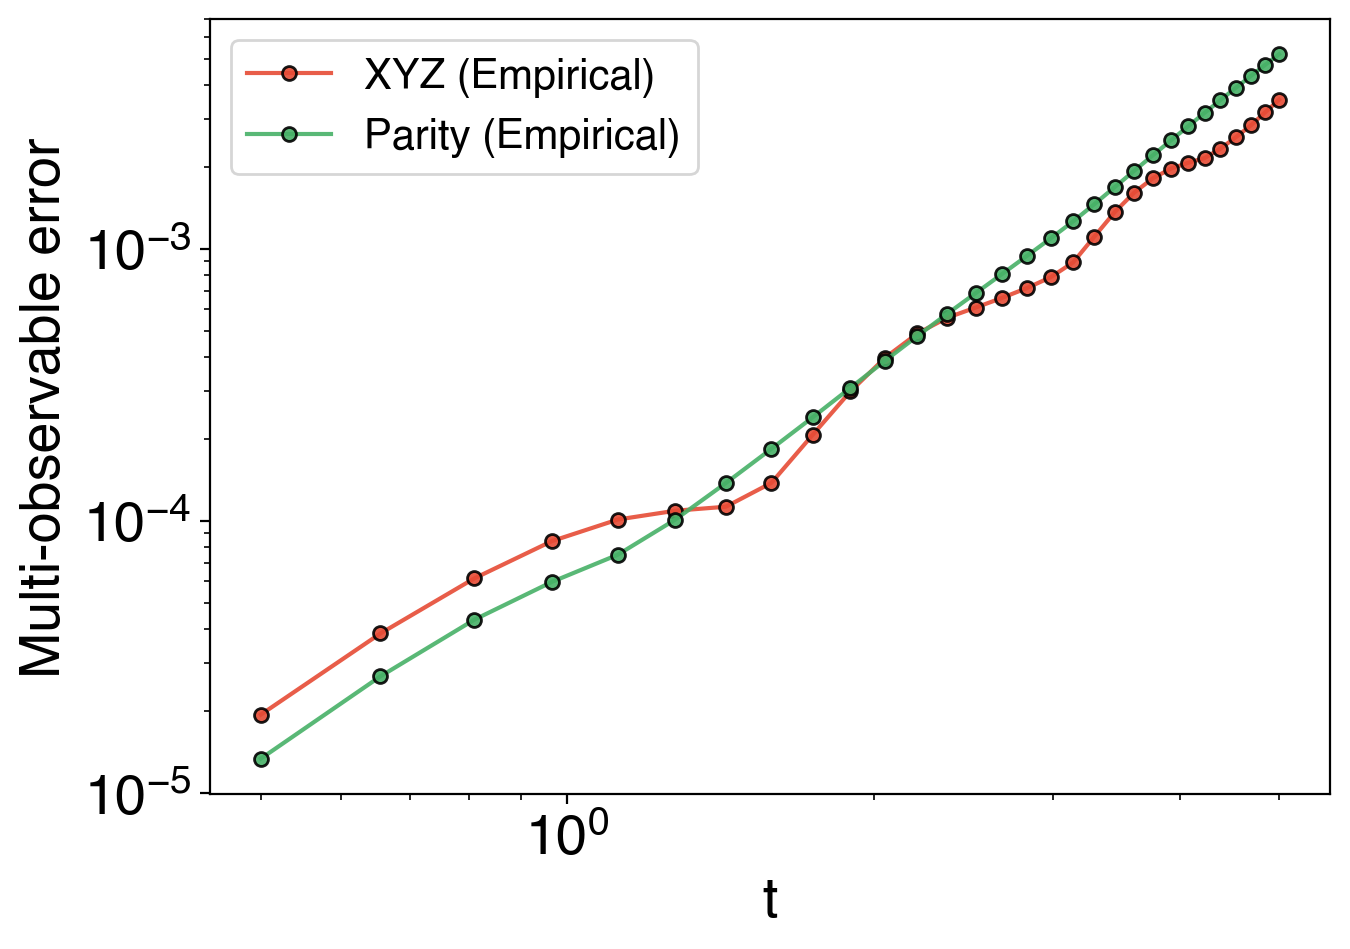

In [ ]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
n = 8; 
r = 30
t = 0.5
t_list = np.linspace(0.5, 5, 30)
# n_list = range(4, 20)
# n_list_emp = range(4, 11)
data = {'error_xyz': [], 'error_parity': [], 'error_xyz_emp': [], 'error_parity_emp': []}
print(f"J={J}, h={h}, t={t}, r={r}")

for t in t_list:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    # z_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
    error_xyz = ob_error(magn_op, exact_U, appro_U_xyz)
    error_parity = ob_error(magn_op, exact_U, appro_U_parity)
    data['error_xyz_emp'].append(error_xyz)
    data['error_parity_emp'].append(error_parity)
    print(f"n={n}, empirical error_xyz={error_xyz:.6f}, empirical error_parity={error_parity:.6f}")  

fig, ax = plt.subplots(figsize=(7, 5), layout='tight')
# ax.plot(n_list, data['error_xyz'], '.--', label='XYZ (Bound)')
# ax.plot(n_list, data['error_parity'], '.--', label='Parity (Bound)')
ax.plot(t_list, data['error_xyz_emp'], '.-', label='XYZ (Empirical)')
ax.plot(t_list, data['error_parity_emp'], '.-', label='Parity (Empirical)')
ax.loglog()
ax.set_xlabel('t')
# ax.set_yscale('log')
ax.set_ylabel('Multi-observable error')
ax.legend() 
